In [47]:
from langchain_community.utilities import SQLDatabase
from langchain_google_vertexai import ChatVertexAI
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough
import re
from tabulate import tabulate 
import matplotlib.pyplot as plt
import uuid

# Used for LangGraph
from typing import TypedDict, Annotated, List, Dict, Any
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

In [37]:
project_id = 'eikon-dev-data-team'
dataset_id = "ancoldbdufanlive"

In [ ]:
# --- 1. Define the State for the Graph ---
# This dictionary will hold the data that moves between the nodes of our graph.
class State(TypedDict):
    question: str
    query: str
    result: str
    structured_result: List[Dict[str, Any]]
    insight: str
    answer: str

In [52]:
db = SQLDatabase.from_uri(f"bigquery://{project_id}/{dataset_id}")
db.get_table_info()

/home/luay9/.venv/lib/python3.12/site-packages/google/cloud/bigquery/client.py:611: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(
/home/luay9/.venv/lib/python3.12/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'INTERVAL' of column 'JAM_MULAI'
  sqlalchemy.util.warn(
/home/luay9/.venv/lib/python3.12/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'INTERVAL' of column 'JAM_SELESAI'
  sqlalchemy.util.warn(


"\nCREATE TABLE `tc_ticketing` (\n\t`NO_TRANSAKSI` STRING, \n\t`NO_TIKET` INT64, \n\t`ID_SHIFT` STRING, \n\t`ID_GATE` STRING, \n\t`TGL_INISIALISASI` DATE, \n\t`SERI_TIKET` STRING, \n\t`NO_TIKET_REAL` INT64, \n\t`STATUS_TIKET` INT64, \n\t`DESCRIPTION_BTL` STRING, \n\t`SUPERVISOR_BTL` STRING, \n\t`STATUS_HTM` INT64, \n\t`USER_UPDATE` STRING, \n\t`LAST_UPDATE` TIMESTAMP, \n\t`BARCODE` STRING, \n\t`datastream_metadata` STRUCT<uuid STRING, source_timestamp INT64>, \n\t`datastream_metadata.uuid` STRING, \n\t`datastream_metadata.source_timestamp` INT64\n)\n\n/*\n3 rows from tc_ticketing table:\nNO_TRANSAKSI\tNO_TIKET\tID_SHIFT\tID_GATE\tTGL_INISIALISASI\tSERI_TIKET\tNO_TIKET_REAL\tSTATUS_TIKET\tDESCRIPTION_BTL\tSUPERVISOR_BTL\tSTATUS_HTM\tUSER_UPDATE\tLAST_UPDATE\tBARCODE\tdatastream_metadata\tdatastream_metadata.uuid\tdatastream_metadata.source_timestamp\n20120630/008/00079\t1\t01\t008\t2012-06-30\tfe\t49908\t1\tNone\tNone\t1\telsa\t2012-06-30 11:28:21+00:00\tNone\t{'uuid': '7d48a0db-917b-47

In [40]:
# --- 2. Define the Nodes for the Graph ---

def write_query(state: State):
    """Generates a SQL query from the user's question."""
    print("---GENERATING SQL QUERY---")
    question = state["question"]
    
    # This part is the same as before, but wrapped in a node function
    llm = ChatVertexAI(model="gemini-2.5-pro")
    
    template = """
    Based on the table schema below, write a SQL query that would answer the user's question.
    Pay attention to use only the column names that you can see in the schema description.
    Be careful to not query for columns that do not exist.
    Pay attention to which column is in which table.
    
    Do not make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

    Table Schema: {schema}
    Question: {question}
    SQL Query:
    """
    prompt = PromptTemplate.from_template(template)
    
    db = SQLDatabase.from_uri(f"bigquery://{project_id}/{dataset_id}")

    def get_schema(_):
        return db.get_table_info()

    sql_query_chain = (
        RunnablePassthrough.assign(schema=get_schema)
        | prompt
        | llm.bind(stop=["\nSQLResult:"])
        | StrOutputParser()
    )

    generated_query = sql_query_chain.invoke({"question": question})
    
    # Clean up the generated query
    clean_query = generated_query.replace("```sql", "").replace("```", "").strip()
    
    return {"query": clean_query}

def check_query(state: State):
    """Validates the SQL query for common mistakes."""
    print("---CHECKING SQL QUERY---")
    query = state["query"]
    llm = ChatVertexAI(model="gemini-2.5-pro")
    db = SQLDatabase.from_uri(f"bigquery://{project_id}/{dataset_id}")

    system = """Double check the user's {dialect} query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query.
If there are no mistakes, just reproduce the original query with no further commentary.

Output the final SQL query only."""
    prompt = ChatPromptTemplate.from_messages(
        [("system", system), ("human", "{query}")]
    ).partial(dialect=db.dialect)
    
    validation_chain = prompt | llm | StrOutputParser()
    
    validated_query_text = validation_chain.invoke({"query": query})

    clean_validated_query = validated_query_text.replace("```sql", "").replace("```", "").strip()

    return {"query": clean_validated_query}

def execute_query(state: State):
    """Executes the SQL query and gets the result."""
    print("---EXECUTING SQL QUERY---")
    query = state["query"]
    db = SQLDatabase.from_uri(f"bigquery://{project_id}/{dataset_id}")
    
    # Use _execute to get structured results
    query_result_dicts = db._execute(query, fetch="all")

    # **NEW:** Format and print the result as a table
    if query_result_dicts:
        headers = query_result_dicts[0].keys()
        data = [list(row.values()) for row in query_result_dicts]
        print("\n--- QUERY RESULT ---")
        print(tabulate(data, headers=headers, tablefmt="grid"))
        print("--------------------\n")
    else:
        print("\n--- QUERY RESULT ---")
        print("Query returned no results.")
        print("--------------------\n")

    # Convert result to string for downstream nodes
    query_result_str = str(query_result_dicts)
    
    return {"result": query_result_str}

def generate_chart(state: State):
    """Generates a bar chart from the query result and saves it to a file."""
    print("---GENERATING CHART---")
    data = state.get("structured_result", [])

    if not data or len(data) < 1 or len(data[0].keys()) < 2:
        print("Query result is not suitable for a chart. Skipping chart generation.")
        return

    try:
        headers = list(data[0].keys())
        # Assume the first column is the label (x-axis) and the second is the value (y-axis)
        labels = [row[headers[0]] for row in data]
        values = [row[headers[1]] for row in data]

        plt.figure(figsize=(10, 6))
        plt.bar(labels, values)
        plt.xlabel(headers[0])
        plt.ylabel(headers[1])
        plt.title(f"Chart of {headers[1]} by {headers[0]}")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        chart_filename = "chart.png"
        plt.savefig(chart_filename)
        print(f"Chart successfully generated and saved as '{chart_filename}'")
        plt.close() # Close the plot to free up memory

    except Exception as e:
        print(f"Could not generate chart: {e}")

    # This node doesn't need to modify the state, it just performs an action.
    return {}

def generate_insight(state: State):
    """Generates insight from the SQL query and its result."""
    print("---GENERATING INSIGHT---")
    query = state["query"]
    result = state["result"]
    
    llm = ChatVertexAI(model="gemini-2.5-pro")

    insight_prompt = PromptTemplate.from_template(
        """
        You are a data analyst. Given the following SQL query and its result,
        provide a brief, one-sentence insight into what the data reveals.

        SQL Query: {query}
        SQL Result: {result}
        Insight:
        """
    )

    insight_chain = insight_prompt | llm
    insight_text = insight_chain.invoke(
        {"query": query, "result": result}
    )
    
    return {"insight": insight_text.content}

def generate_answer(state: State):
    """Generates a natural language answer from the SQL query result and insight."""
    print("---GENERATING FINAL ANSWER---")
    question = state["question"]
    result = state["result"]
    insight = state["insight"]
    
    llm = ChatVertexAI(model="gemini-2.5-pro")

    answer_prompt = PromptTemplate.from_template(
        """
        Given the user's question and the data insight, provide a final answer.

        Question: {question}
        Insight: {insight}
        Data Result (for context): {result}
        Final Answer:
        """
    )

    answer_chain = answer_prompt | llm
    final_answer = answer_chain.invoke(
        {"question": question, "insight": insight, "result": result}
    )
    
    return {"answer": final_answer.content}

In [43]:
# --- 3. Build and Compile the Graph ---

# This sets up the memory for our graph, allowing it to be paused and resumed.
memory = MemorySaver()

# Define the graph structure
graph_builder = StateGraph(State)

# Add the nodes
graph_builder.add_node("write_query", write_query)
graph_builder.add_node("check_query", check_query) # New validation node
graph_builder.add_node("execute_query", execute_query)
graph_builder.add_node("generate_chart", generate_chart)
graph_builder.add_node("generate_insight", generate_insight)
graph_builder.add_node("generate_answer", generate_answer)

# Define the edges (the flow of control)
graph_builder.add_edge(START, "write_query")
graph_builder.add_edge("write_query", "check_query")
graph_builder.add_edge("check_query", "execute_query")
graph_builder.add_edge("execute_query", "generate_chart")
graph_builder.add_edge("generate_chart", "generate_insight")
graph_builder.add_edge("generate_insight", "generate_answer")
graph_builder.add_edge("generate_answer", END)

# Compile the graph, setting the interruption point
# The graph will pause *before* executing the 'execute_query' node.
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["execute_query"]
)

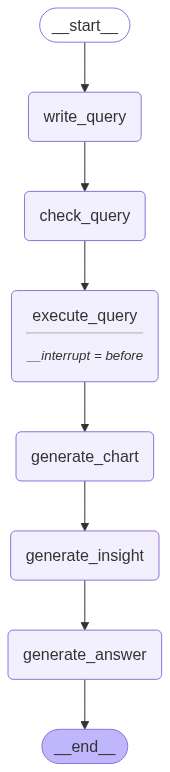

In [44]:
graph

In [49]:
def bigquery_qa_with_human_approval(p_id: str, d_id: str, q: str):
    """
    Runs the BigQuery Q&A process with a human approval step.
    """
    global project_id, dataset_id
    project_id = p_id
    dataset_id = d_id
    
    thread_id = str(uuid.uuid4())
    config = {"configurable": {"thread_id": thread_id}}
    
    initial_state = {"question": q}
    
    for step in graph.stream(initial_state, config, stream_mode="values"):
        print(step)
    
    current_state = graph.get_state(config)
    generated_query = current_state.values.get("query")
    print("\n--- PENDING SQL QUERY ---")
    print(generated_query)
    print("-------------------------\n")

    try:
        user_approval = input("Do you want to execute this query? (yes/no): ")
    except Exception:
        user_approval = "no"

    if user_approval.lower() == "yes":
        print("\n--- QUERY APPROVED ---")
        for step in graph.stream(None, config, stream_mode="values"):
            print(step)
    else:
        print("\n--- QUERY DENIED ---")
        print("Operation cancelled by user.")

In [50]:
project_id = project_id  # Replace with your project ID
dataset_id = dataset_id  # Replace with your dataset ID
question = "Berapa jumlah tiket yang terjual di tanggal paling terakhir?"  # Replace with your question

bigquery_qa_with_human_approval(project_id, dataset_id, question)

{'question': 'Berapa jumlah tiket yang terjual di tanggal paling terakhir?'}
---GENERATING SQL QUERY---


/home/luay9/.venv/lib/python3.12/site-packages/google/cloud/bigquery/client.py:611: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(
/home/luay9/.venv/lib/python3.12/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'INTERVAL' of column 'JAM_MULAI'
  sqlalchemy.util.warn(
/home/luay9/.venv/lib/python3.12/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'INTERVAL' of column 'JAM_SELESAI'
  sqlalchemy.util.warn(


{'question': 'Berapa jumlah tiket yang terjual di tanggal paling terakhir?', 'query': 'SELECT sum(JML_TIKET_BYR) FROM tt_tiketing WHERE date(TGL_TRANSAKSI) = (SELECT max(date(TGL_TRANSAKSI)) FROM tt_tiketing)'}
---CHECKING SQL QUERY---


/home/luay9/.venv/lib/python3.12/site-packages/google/cloud/bigquery/client.py:611: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(
/home/luay9/.venv/lib/python3.12/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'INTERVAL' of column 'JAM_MULAI'
  sqlalchemy.util.warn(
/home/luay9/.venv/lib/python3.12/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'INTERVAL' of column 'JAM_SELESAI'
  sqlalchemy.util.warn(


{'question': 'Berapa jumlah tiket yang terjual di tanggal paling terakhir?', 'query': 'SELECT sum(JML_TIKET_BYR) FROM tt_tiketing WHERE date(TGL_TRANSAKSI) = (SELECT max(date(TGL_TRANSAKSI)) FROM tt_tiketing)'}

--- PENDING SQL QUERY ---
SELECT sum(JML_TIKET_BYR) FROM tt_tiketing WHERE date(TGL_TRANSAKSI) = (SELECT max(date(TGL_TRANSAKSI)) FROM tt_tiketing)
-------------------------


--- QUERY APPROVED ---
{'question': 'Berapa jumlah tiket yang terjual di tanggal paling terakhir?', 'query': 'SELECT sum(JML_TIKET_BYR) FROM tt_tiketing WHERE date(TGL_TRANSAKSI) = (SELECT max(date(TGL_TRANSAKSI)) FROM tt_tiketing)'}
---EXECUTING SQL QUERY---


/home/luay9/.venv/lib/python3.12/site-packages/google/cloud/bigquery/client.py:611: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(
/home/luay9/.venv/lib/python3.12/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'INTERVAL' of column 'JAM_MULAI'
  sqlalchemy.util.warn(
/home/luay9/.venv/lib/python3.12/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'INTERVAL' of column 'JAM_SELESAI'
  sqlalchemy.util.warn(



--- QUERY RESULT ---
+-------+
|   f0_ |
+=======+
|  3649 |
+-------+
--------------------

{'question': 'Berapa jumlah tiket yang terjual di tanggal paling terakhir?', 'query': 'SELECT sum(JML_TIKET_BYR) FROM tt_tiketing WHERE date(TGL_TRANSAKSI) = (SELECT max(date(TGL_TRANSAKSI)) FROM tt_tiketing)', 'result': "[{'f0_': 3649}]"}
---GENERATING CHART---
Query result is not suitable for a chart. Skipping chart generation.
---GENERATING INSIGHT---
{'question': 'Berapa jumlah tiket yang terjual di tanggal paling terakhir?', 'query': 'SELECT sum(JML_TIKET_BYR) FROM tt_tiketing WHERE date(TGL_TRANSAKSI) = (SELECT max(date(TGL_TRANSAKSI)) FROM tt_tiketing)', 'result': "[{'f0_': 3649}]", 'insight': 'The total number of tickets paid for on the most recent day of transactions was 3,649.'}
---GENERATING FINAL ANSWER---
{'question': 'Berapa jumlah tiket yang terjual di tanggal paling terakhir?', 'query': 'SELECT sum(JML_TIKET_BYR) FROM tt_tiketing WHERE date(TGL_TRANSAKSI) = (SELECT max(date(TGL